In [1]:
import sys
home_dir = '../'
sys.path.append(home_dir)
print(sys.path)

import numpy as np
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt
from steevebase.io import load_sequence, save_sequence
import math

%matplotlib notebook

['', '/usr/bin/python', '/home/ec2-user/steem_ailib/nbs', '/home/ec2-user/miniconda3/lib/python36.zip', '/home/ec2-user/miniconda3/lib/python3.6', '/home/ec2-user/miniconda3/lib/python3.6/lib-dynload', '/home/ec2-user/miniconda3/lib/python3.6/site-packages', '/home/ec2-user/miniconda3/lib/python3.6/site-packages/Mako-1.0.7-py3.6.egg', '/home/ec2-user/steem_ailib/piston-lib', '/home/ec2-user/steem_ailib', '/home/ec2-user/miniconda3/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg', '/home/ec2-user/miniconda3/lib/python3.6/site-packages/IPython/extensions', '/home/ec2-user/.ipython', '../']


In [2]:
what_is_good_threshold = 0.044

In [3]:
def combine_preds_orig(predictions):
    neg = 1-predictions[:,0]
    pos = predictions[:,1]
#     res = np.rint((neg + pos) / 2).astype(int)
    return (neg + pos) / 2

def combine_preds(predictions):
#     return np.rint(predictions[:, 1]).astype(int)
    return predictions[:, 1]

def load_plot_data(plot_data_name):
    vis_data = np.load(plot_data_name)
    vis_data = dict(vis_data) # because of lazy loading

#     print(vis_data.keys())

    y_true = vis_data['net_votes'] / np.max(vis_data['net_votes'])
    y_pred = vis_data['predictions']

    nonz = np.sum(y_pred, axis=-1) != 0.
    nonz = np.sum(nonz, axis=-1) != 0.
    y_pred = y_pred[nonz]

    y_pred_combined = np.zeros((y_pred.shape[0], y_pred.shape[1]))
    diff = 0
    for i in range(y_pred.shape[0]):
        y_pred_combined[i] = combine_preds(y_pred[i])
        diff += np.sum(np.abs(1-y_pred[i][:,0]-y_pred[i][:,1]))

    diff /= y_pred.shape[0] * y_pred.shape[1]
#     print("Diff = %f" % diff)

    y_pred = y_pred_combined
    
    return vis_data, y_pred, y_true

def create_eval_set(data_bin, training_config_path, val_or_test):
    from steevebase.io import load_training_config
    training_config = load_training_config(training_config_path)
    TR_CONFIG = training_config['TRAINING']
    TEST2TRAIN_RATIO = TR_CONFIG['TEST2TRAIN_RATIO']
    BATCH_SIZE = TR_CONFIG['BATCH_SIZE']
    TEST_SAMPLES = TR_CONFIG['TEST_SAMPLES']
    
    print(
        'Using:\n\tTEST2TRAIN_RATIO: %.4f\n\tBATCH_SIZE: %d\n\tTEST_SAMPLES: %d' %
        (TEST2TRAIN_RATIO, BATCH_SIZE, TEST_SAMPLES)
         )
    
    
    training_set_size = int(math.floor(len(data_bin) * (1-TEST2TRAIN_RATIO)))
    
    if val_or_test == 'val':
        start = training_set_size
    elif val_or_test == 'test':
        start = training_set_size + TEST_SAMPLES
    else:
        raise RuntimeError('Choose val or test.')
        

    data = data_bin[start:start+TEST_SAMPLES]

    data = sorted(data, key = lambda x: min(max(x['net_votes']/2000,0), 1), reverse=True)

    print("%s set size: %d" % (val_or_test, TEST_SAMPLES))
    
    return data

In [ ]:
def print_conf_mat(conf_mat):
    print("%d %d | %f" % (conf_mat[0,0], conf_mat[0,1], conf_mat[0,2]))
    print("%d %d | %f" % (conf_mat[1,0], conf_mat[1,1], conf_mat[1,2]))
        
def plot_it(all_predictions, vis_data, index):
    predictions = all_predictions[index]
    conf_mat = vis_data['conf_mats'][index]
    label = vis_data['label_categorical']
    
    plt.figure()
    
    plt.plot(y_true)
    plt.plot(predictions, ".")

    # plot delimiters TP / FP / TN / FN
    pos = label[label == 1]
    num_pos = len(pos)
    plt.plot([num_pos, num_pos], [0, 1], "k")
    plt.plot([0, len(y_true)], [0.5, 0.5], "k")
    
    # plot means
    pos_mean = np.mean(predictions[:num_pos])
    neg_mean = np.mean(predictions[num_pos:])
    
    plt.plot([0,num_pos],[pos_mean, pos_mean],'r')
    plt.plot([num_pos, len(predictions)],[neg_mean, neg_mean],'r')
    
    print_conf_mat(conf_mat)
    print()    
    simple_projection_epoch(epoch=index)
    
    return num_pos


def voting_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True):
    
    # good and bad generally don't sum up to total (we are skipping plagiarism, too short posts
    # and then some in labeling) - not accounted for here
    daily_good_posts = good_posts / total_posts * daily_posts
    daily_bad_posts = bad_posts / total_posts * daily_posts
    
    daily_good_votes = model_tpr * daily_good_posts
    daily_bad_votes = model_fpr * daily_bad_posts
    
    daily_votes_total = daily_good_votes + daily_bad_votes
    
    if daily_votes_total >= daily_votes:
        # only when subsampling necessary (otherwise model would vote more often then than we want)
        # -> rescaling the good / bad ratio to daily_votes
        daily_good_votes_rescaled = int(daily_votes * daily_good_votes / daily_votes_total)
        daily_bad_votes_rescaled = daily_votes - daily_good_votes_rescaled
    
    else:
        daily_good_votes_rescaled = int(daily_good_votes)
        daily_bad_votes_rescaled = int(daily_bad_votes)
    
    pos_ratio = (daily_good_votes_rescaled + daily_bad_votes_rescaled) / (daily_posts)
    
    if printout:
        print("voting_projection: Daily good votes: %d / %d, bad: %d / %d, pos_ratio: %.6f" % (
            daily_good_votes_rescaled,
            daily_good_posts,
            daily_bad_votes_rescaled,
            daily_bad_posts,
            pos_ratio
        ))

    return daily_good_votes_rescaled


def simple_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True):
    
    # good and bad generally don't sum up to total (we are skipping plagiarism, too short posts
    # and then some in labeling) - not accounted for here
    daily_good_posts = good_posts / total_posts * daily_posts
    daily_bad_posts = bad_posts / total_posts * daily_posts
    
    daily_good_votes = model_tpr * daily_good_posts
    daily_bad_votes = model_fpr * daily_bad_posts
    
#     daily_votes_total = daily_good_votes + daily_bad_votes
    
    if printout:
#         print("Daily good posts: %d, bad: %d" % (daily_good_posts, daily_bad_posts))
        print("simple_projection: Daily good votes: %d, bad: %d, total: %d" % (daily_good_votes, daily_bad_votes,daily_good_votes+daily_bad_votes))
    
    return daily_good_votes - daily_bad_votes


def simple_projection_2(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True):
    
    # good and bad generally don't sum up to total (we are skipping plagiarism, too short posts
    # and then some in labeling) - not accounted for here
    daily_good_posts = good_posts / total_posts * daily_posts
    daily_bad_posts = bad_posts / total_posts * daily_posts
    
    daily_good_votes = model_tpr * daily_good_posts
    daily_bad_votes = model_fpr * daily_bad_posts
    
#     daily_votes_total = daily_good_votes + daily_bad_votes
    
    if printout:
#         print("Daily good posts: %d, bad: %d" % (daily_good_posts, daily_bad_posts))
        print("simple_projection 2: Daily good votes: %d, bad: %d, total: %d" % (daily_good_votes, daily_bad_votes,daily_good_votes+daily_bad_votes))
    
    return daily_good_votes / daily_bad_votes


def diff_of_means(predictions, vis_data):
    label = vis_data['label_categorical']
    pos = label[label == 1]
    num_pos = len(pos)
    pos_mean = np.mean(predictions[:num_pos])
    neg_mean = np.mean(predictions[num_pos:])
    return pos_mean - neg_mean

    
def simple_projection_epoch(epoch):
    model_tpr = vis_data['conf_mats'][epoch][1,2]
    model_fpr = 1 - vis_data['conf_mats'][epoch][0,2]
    simple_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True)
    voting_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True)


def calc_projection(proj):
    good_posts_stats = [
        proj(conf_mat[1,2], 1 - conf_mat[0,2], total_posts, good_posts, bad_posts, daily_posts,
             daily_votes, printout=False) for conf_mat in vis_data['conf_mats']
    ]
    good_posts_stats = np.array(good_posts_stats)
    good_posts_stats[np.isnan(good_posts_stats)] = 0
    return good_posts_stats
    
def show_projection(proj, printout=False):
    good_posts_stats = calc_projection(proj)
    
    proj_argmax = good_posts_stats.argmax()
    print('%s: Best model is #%d with metric value: %.2f'
          % (proj.__name__, proj_argmax, good_posts_stats.max()))
    plt.figure()
    plt.title(proj.__name__)
    plt.plot(good_posts_stats);
    
    num_pos = plot_it(y_pred, vis_data, proj_argmax)
    
    return good_posts_stats

def min_max_rescale(x):
    min_val = np.min(x)
    max_val = np.max(x)
    return (x - min_val) / (max_val - min_val)

def compare_all():
    voting = calc_projection(voting_projection)
    voting = min_max_rescale(voting)
    
    simple = calc_projection(simple_projection)
    simple = min_max_rescale(simple)
    
#     simple2 = calc_projection(simple_projection_2)
#     simple2 = min_max_rescale(simple2)
    
    diffs_of_means = [
        diff_of_means(pred, vis_data) for pred in y_pred
    ]
    diffs_of_means = np.array(diffs_of_means)
    diffs_of_means = min_max_rescale(diffs_of_means)
    
    #     res = voting + simple + simple2 + diffs_of_means
    res = voting + simple + diffs_of_means
#     res = min_max_rescale(res)
    
    plt.figure()
    plt.title('Compare all')
    plt.plot(voting, label='voting_projection')
    plt.plot(simple, label='simple_projection')
#     plt.plot(simple2, label='simple_projection_2')
    plt.plot(diffs_of_means, label='diffs_of_means')
    plt.plot(res, 'k', label='sum')
    plt.legend()
    
    proj_argmax = res.argmax()
    
    print('%s: Best model is #%d'
          % ('Sum all', proj_argmax))
    
    num_pos = plot_it(y_pred, vis_data, proj_argmax)

In [28]:
# vis_data, y_pred = load_plot_data('../training/2017_08_29_capital/plot_data.npz')
# vis_data, y_pred = load_plot_data('../training_2017_10_22/plot_data.npz')
# vis_data, y_pred = load_plot_data('../training_2017_10_23/plot_data.npz')
vis_data, y_pred, y_true = load_plot_data('../data/plot_data.npz')

# Automated selection w.r.t. max good votes

#### Get number of posts per day

In [13]:
from pymongo import MongoClient
from datetime import datetime, timedelta

TIME_FORMAT = '%Y-%m-%d %H:%M:%S'

mongo_address = 'mongodb://107.155.87.82:26999'
# mongo_address = 'mongodb://localhost:26999'
client = MongoClient(mongo_address)
db = client.get_database('steem_posts')
db.authenticate("admin","dmw]SR%u6Ct!", source='admin')
raw_posts_col = db.get_collection("raw_posts")
clean_posts_col = db.get_collection("clean_posts")

query = {}
ineq_dict = {}

days = 5
delay = 2
ineq_dict['$lte'] = datetime.utcnow() - timedelta(days=delay)
ineq_dict['$gte'] = ineq_dict['$lte'] - timedelta(days=days)

query['created'] = ineq_dict

raw_daily_posts = int(raw_posts_col.find(query).count() / days)
print('Raw daily posts averaged over %d days: %d' % (days, raw_daily_posts))
daily_posts = int(clean_posts_col.find(query).count() / days)
print('Clean daily posts averaged over %d days: %d' % (days, daily_posts))

Raw daily posts averaged over 5 days: 42165
Clean daily posts averaged over 5 days: 16968


In [26]:
total_posts = 1335271 # posts after filtering
# filtered_posts = 103547 # all posts without plagiarism and too short posts

good_posts = 442449 # posts from training labeled as positive
bad_posts = 892822 # posts from training labeled as negative

# Source: https://docs.google.com/spreadsheets/d/1KrUFgbb0SxvqNKpkl4prgX5xcrEh7aCjIl9_N64_8eM
daily_votes = 2000

<IPython.core.display.Javascript object>


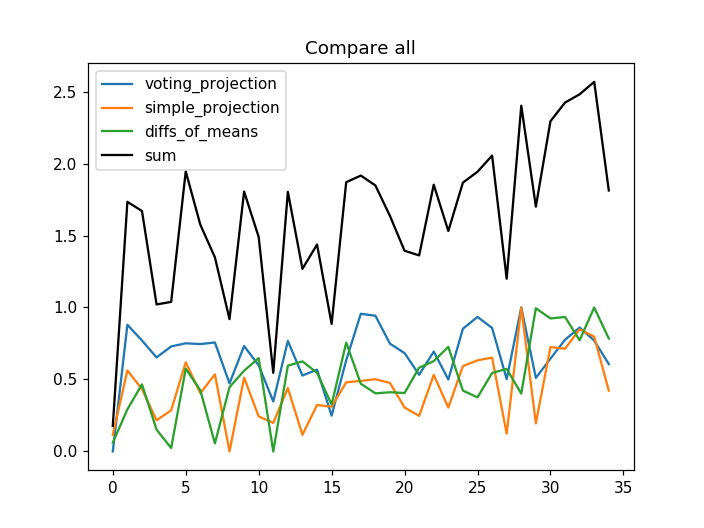

Sum all: Best model is #33


<IPython.core.display.Javascript object>


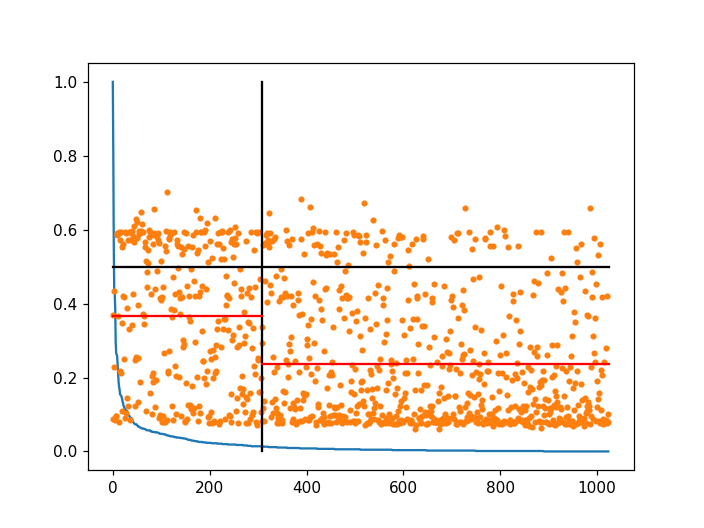

623 92 | 0.871329
195 114 | 0.368932

simple_projection: Daily good votes: 2074, bad: 1459, total: 3534
voting_projection: Daily good votes: 1173 / 5622, bad: 827 / 11345, pos_ratio: 0.117869


In [29]:
compare_all()

voting_projection: Best model is #258 with metric value: 1060.00


/home/ec2-user/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


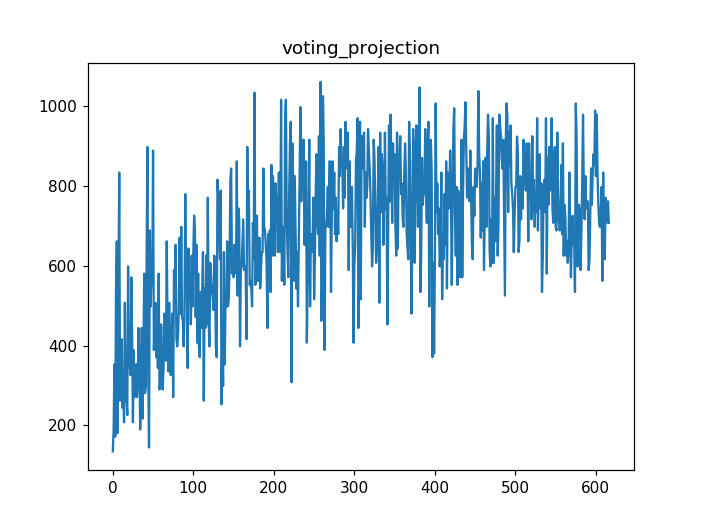

<IPython.core.display.Javascript object>


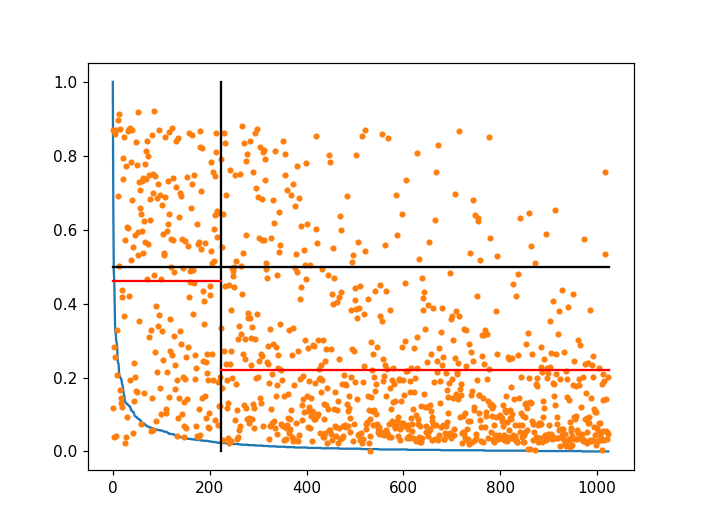

704 97 | 0.878901
106 117 | 0.524664

simple_projection: Daily good votes: 1060, bad: 926, total: 1986
voting_projection: Daily good votes: 1060 / 2021, bad: 926 / 7649, pos_ratio: 0.205356


In [86]:
good_posts_stats = show_projection(voting_projection)

simple_projection: Best model is #291 with metric value: 346.42


/home/ec2-user/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


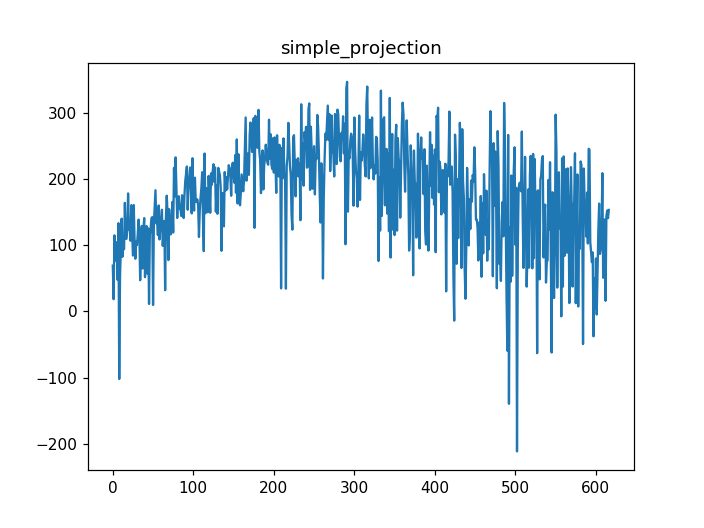

<IPython.core.display.Javascript object>


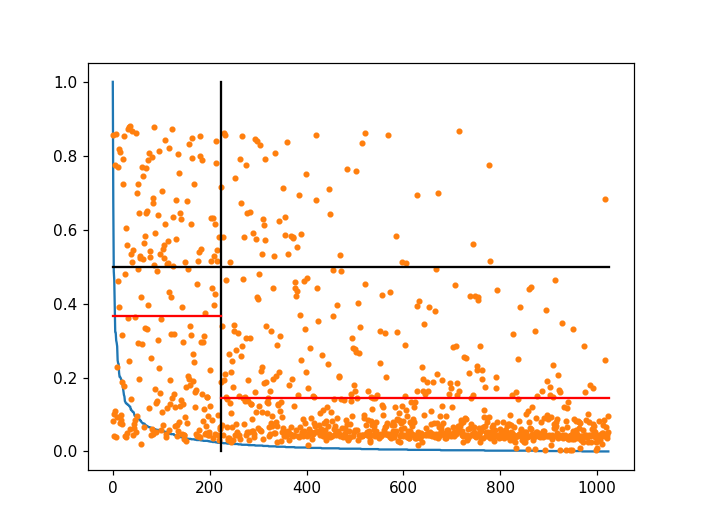

749 52 | 0.935081
130 93 | 0.417040

simple_projection: Daily good votes: 843, bad: 496, total: 1339
voting_projection: Daily good votes: 843 / 2021, bad: 496 / 7649, pos_ratio: 0.138455


In [77]:
good_posts_stats = show_projection(simple_projection)

In [79]:
# lower number of good votes, but they would be stronger due to the overall lower number of votes
1986 / 1339 * 843

1250.3345780433158

simple_projection_2: Best model is #139 with metric value: 2.47


/home/ec2-user/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


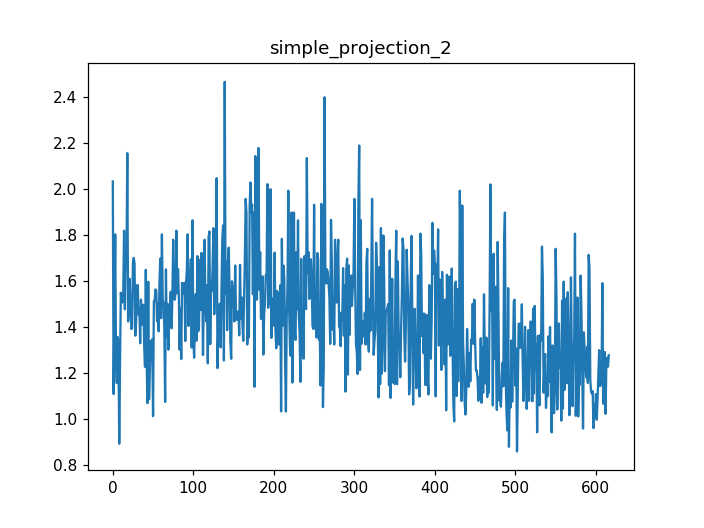

<IPython.core.display.Javascript object>


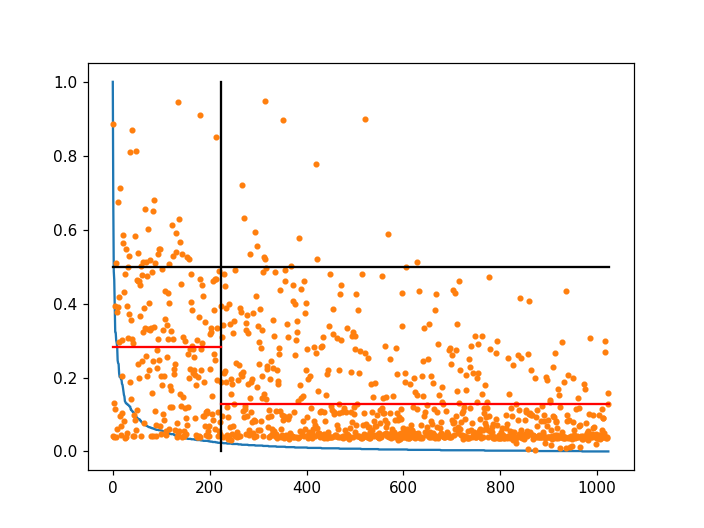

786 15 | 0.981273
184 39 | 0.174888

simple_projection: Daily good votes: 353, bad: 143, total: 496
voting_projection: Daily good votes: 353 / 2021, bad: 143 / 7649, pos_ratio: 0.051287


In [80]:
good_posts_stats = show_projection(simple_projection_2)

# Maximize separation (difference between class means)

Best model is #502 with 0.86 good votes out of 2000


/home/ec2-user/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


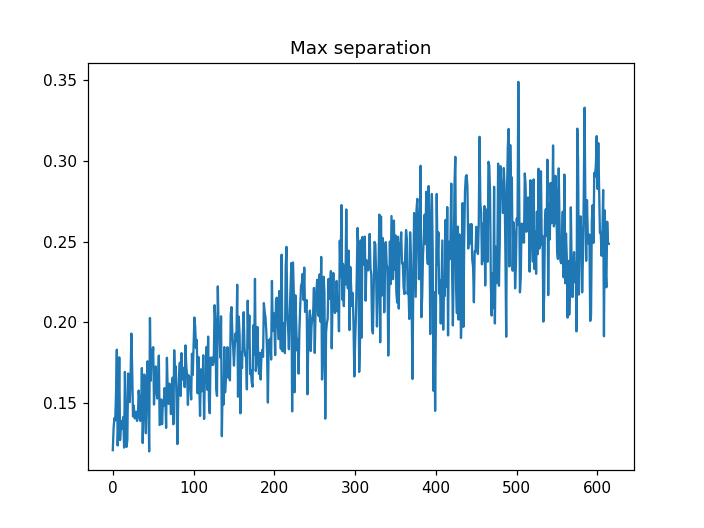

<IPython.core.display.Javascript object>


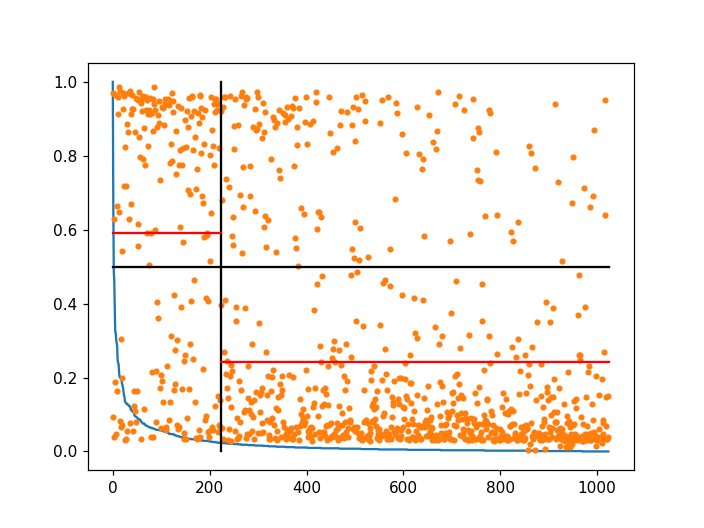

646 155 | 0.806492
83 140 | 0.627803

simple_projection: Daily good votes: 1269, bad: 1480, total: 2749
voting_projection: Daily good votes: 923 / 2021, bad: 1077 / 7649, pos_ratio: 0.206804


In [74]:
diffs_of_means = [
    diff_of_means(pred, vis_data) for pred in y_pred
]
diffs_of_means = np.array(diffs_of_means)
diffs_argmax = diffs_of_means.argmax()
print('Best model is #%d with %.2f good votes out of %d' % (diffs_argmax, good_posts_stats[diffs_argmax], daily_votes))
plt.figure()
plt.title('Max separation')
plt.plot(diffs_of_means);

num_pos = plot_it(y_pred, vis_data, diffs_argmax)

/home/ec2-user/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


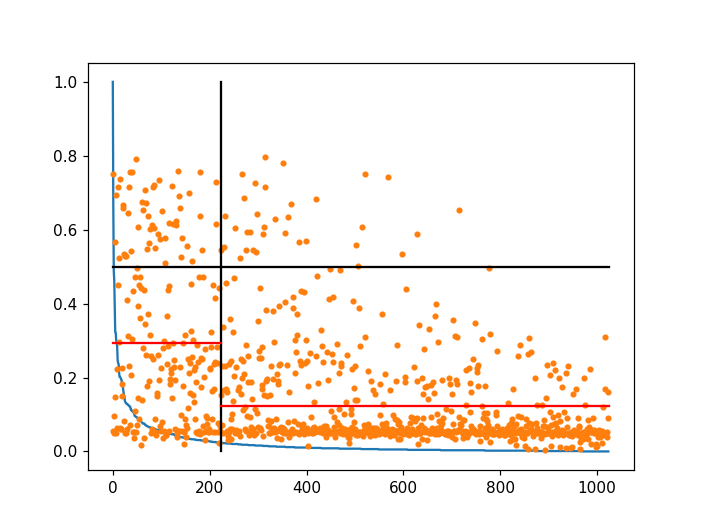

774 27 | 0.966292
161 62 | 0.278027

simple_projection: Daily good votes: 562, bad: 257, total: 819
voting_projection: Daily good votes: 562 / 2021, bad: 257 / 7649, pos_ratio: 0.084686


In [81]:
num_pos = plot_it(y_pred, vis_data, 181)

In [82]:
1986 / 819 * 562

1362.7985347985348

<IPython.core.display.Javascript object>


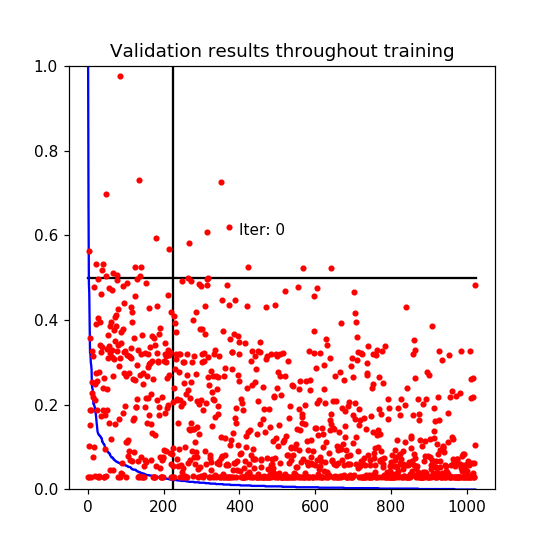

In [37]:
plt.close()
fig, ax = plt.subplots(1,1,figsize=(5,5))

label = vis_data['label_categorical']

ax.set_title("Validation results throughout training")
ax.set_ylim((0, 1))

idx = np.arange(y_pred.shape[1])

num_pos = len(label[label == 1])
ax.plot([num_pos, num_pos], [0, 1], "k")
ax.plot([0, len(y_true)], [0.5, 0.5], "k")
    
ax.plot(idx, y_true, 'b') # already normalized and sorted
lines, = ax.plot(idx, y_pred[0], "r.") # already normalized and sorted

text_field = ax.text(400, 0.6,'')

def animate(i):
    lines.set_data(idx, y_pred[i%y_pred.shape[0]])
    text_field.set_text("Iter: %d" % (i % y_pred.shape[0]))
    return lines

anim = FuncAnimation(fig, animate, frames=range(y_pred.shape[0]), interval=300, repeat_delay=5000)

# False Positive Posts
- Find False Positive Posts
- Sort them according to the model's prediction in a decreasing manner
- Inspect

In [18]:
from IPython.core.display import display, HTML

def filter_and_show_links(data, values):
    for post,value in zip(data, values):
        if value > 0.5:
            link = post['url']
            pp = post['title'] + "+" + post['body']
            post_len = len(pp)
            display(HTML("""<a href="https://steemit.com%s">[%.4f / %d] %s</a>""" % (link, value, post_len, link)))
#             print(pp)

In [19]:
data_bin = load_sequence("../data/data.jsonl")
len(data_bin)

69979

In [20]:
from steevebase.io import load_training_config
training_config = load_training_config("../training_configs/default_training_setup.json")
TR_CONFIG = training_config['TRAINING']
TEST2TRAIN_RATIO = TR_CONFIG['TEST2TRAIN_RATIO']
BATCH_SIZE = TR_CONFIG['BATCH_SIZE']
TEST_SAMPLES = TR_CONFIG['TEST_SAMPLES']

Test set size: 2048


<IPython.core.display.Javascript object>


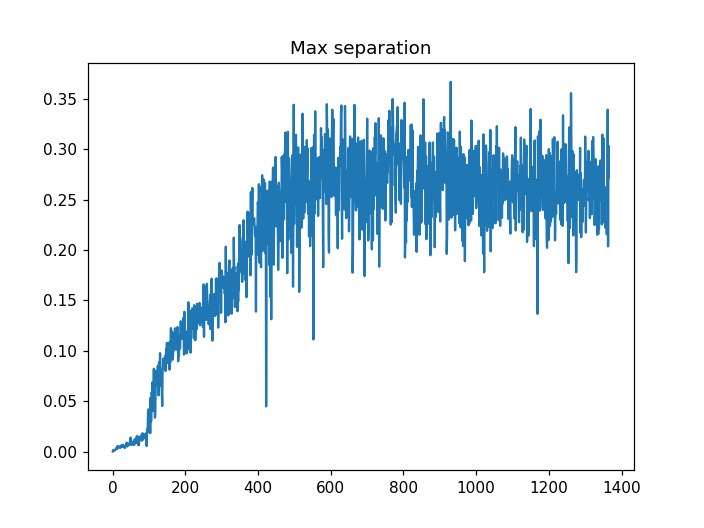

<IPython.core.display.Javascript object>


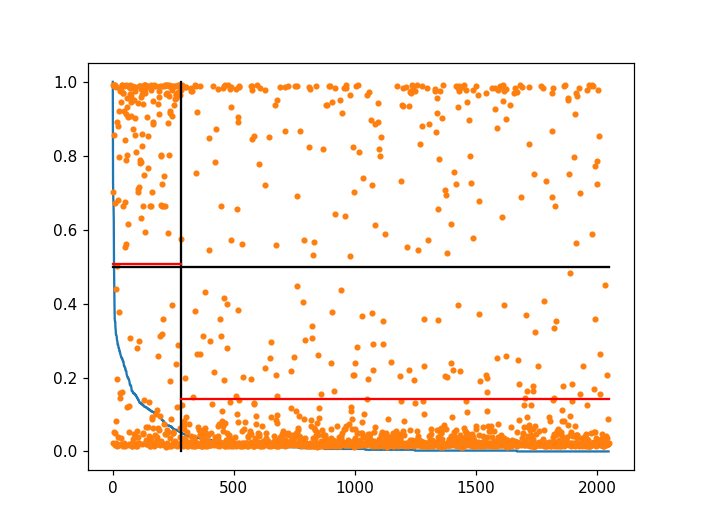

1556 209 | 0.881586
133 150 | 0.530035

simple_projection: Daily good votes: 420, bad: 554, total >= 975
voting_projection:
	Daily good posts: 793, bad: 4682
	Daily good votes: 86, bad: 114


In [21]:
diffs_of_means = [
    diff_of_means(pred, vis_data) for pred in y_pred
]
diffs_of_means = np.array(diffs_of_means)
diffs_argmax = diffs_of_means.argmax()
# print('Best model is #%d with %.2f good votes out of %d' % (diffs_argmax, good_posts_stats[diffs_argmax], daily_votes))
plt.figure()
plt.title('Max separation')
plt.plot(diffs_of_means);

num_pos = plot_it(y_pred, vis_data, diffs_argmax)

/home/ec2-user/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


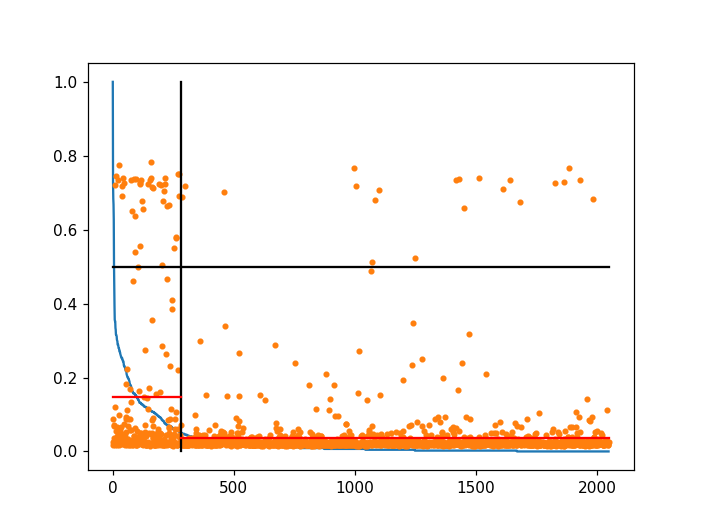

1744 21 | 0.988102
242 41 | 0.144876

simple_projection: Daily good votes: 115, bad: 55, total >= 170
voting_projection:
	Daily good posts: 793, bad: 4682
	Daily good votes: 115, bad: 85


In [263]:
num_pos = plot_it(y_pred, vis_data, 552)

<IPython.core.display.Javascript object>


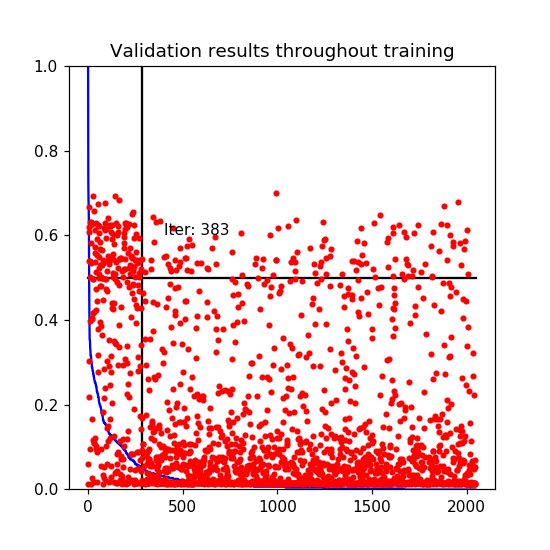

In [52]:
plt.close()
fig, ax = plt.subplots(1,1,figsize=(5,5))

label = vis_data['label_categorical']

ax.set_title("Validation results throughout training")
ax.set_ylim((0, 1))

idx = np.arange(y_pred.shape[1])

num_pos = len(label[label == 1])
ax.plot([num_pos, num_pos], [0, 1], "k")
ax.plot([0, len(y_true)], [0.5, 0.5], "k")
    
ax.plot(idx, y_true, 'b') # already normalized and sorted
lines, = ax.plot(idx, y_pred[0], "r.") # already normalized and sorted

text_field = ax.text(400, 0.6,'')

def animate(i):
    lines.set_data(idx, y_pred[i%y_pred.shape[0]])
    text_field.set_text("Iter: %d" % (i % y_pred.shape[0]))
    return lines

anim = FuncAnimation(fig, animate, frames=range(y_pred.shape[0]), interval=300, repeat_delay=5000)

# False Positive Posts
- Find False Positive Posts
- Sort them according to the model's prediction in a decreasing manner
- Inspect

In [95]:
from IPython.core.display import display, HTML

def filter_and_show_links(data, values):
    for post,value in zip(data, values):
        if value > 0.5:
            link = post['url']
            pp = post['title'] + "+" + post['body']
            post_len = len(pp)
            display(HTML("""<a href="https://steemit.com%s">[%.4f / %d] %s</a>""" % (link, value, post_len, link)))
#             print(pp)

In [96]:
data_bin = load_sequence("../data/data.jsonl")
len(data_bin)

89495

In [98]:
test_data_bin = create_eval_set("../training_configs/default_training_setup.json", 'val')

Test set size: 2048


In [105]:
# idx = -1
idx = 38

print("Examining epoch: %d" % idx)

neg_data = test_data_bin[num_pos:]
neg_pred = y_pred[idx][num_pos:]

# neg_links = [post[3] for post in neg_data]

sorted_idx = np.argsort(neg_pred)[::-1]

neg_data_sorted = [neg_data[i] for i in sorted_idx]

neg_pred = neg_pred[sorted_idx]

Examining epoch: 38


In [23]:
filter_and_show_links(neg_data_sorted[:100], neg_pred[:100])

In [117]:
neg_data_sorted[14]['url']

496